# 📌 Building a Neural Network from Scratch using only Numpy

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import os
import zipfile

In [3]:
directory = 'dataset/'
files = os.listdir(directory)

In [4]:
with zipfile.ZipFile(directory + 'train.csv.zip', 'r') as zip:
    zip.extractall('dataset/')

In [5]:
data = pd.read_csv('dataset/train.csv')

In [6]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
data = np.array(data)
m, n = data.shape
np.random.shuffle(data)

data_test = data[0:1000].T
Y_test = data_test[0]
X_test = data_test[1:n]
X_test = X_test / 255.

data_train = data[1000:m].T
Y_train = data_train[0]
X_train = data_train[1:n]
X_train = X_train / 255.

In [8]:
X_train[:, 0].shape

(784,)

Plot an example image

Label: 6


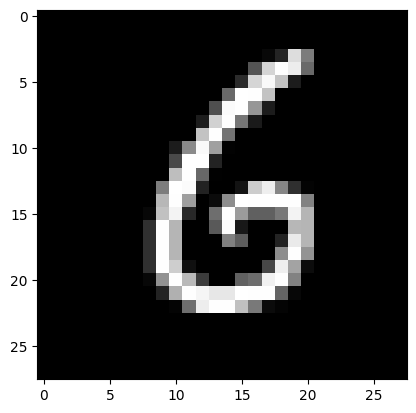

In [9]:
current_image = X_train[:, 5, None]
label = Y_train[5]
print(f"Label: {label}")

current_image = current_image.reshape((28, 28)) * 255
plt.gray()
plt.imshow(current_image)
plt.show()

Visualize a grid of images

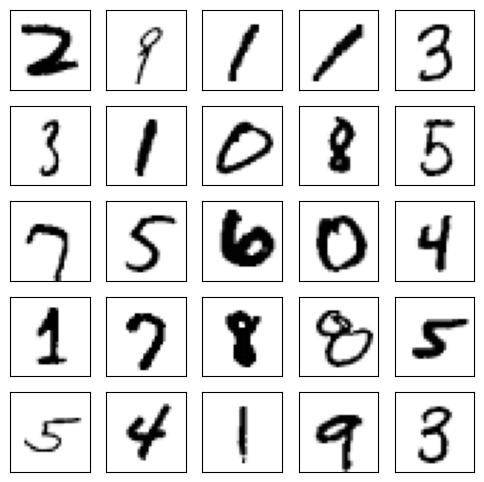

In [22]:
plt.figure(figsize=(6,6))
for i,image in enumerate(data[0:25]):
    
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    image = image[1:].reshape((28, 28)) * 255
    plt.imshow(image, cmap='Greys')


### Some information
Our NN will have a simple two-layer architecture:
-  Input layer $A^{[0]}$ will have 784 units corresponding to the 784 pixels in each 28x28x1 input image;
- A hidden layer $A^{[1]}$ will have 10 units with ReLU activation; 
- the output layer $a^{[2]}$ will have 10 units corresponding to the 10-digit classes with softmax activation.


In order to have a NN with good accuracy performance in prediction we have to implement 3 main phases that will compose the training algorithm:
- **Forward propagation**
- **Backward propagation**
- **Parameter updates**

### Parameters initialization

In [9]:
def init_params():
    W1 = np.random.normal(size=(10, 784)) * np.sqrt(1./(784))
    b1 = np.random.normal(size=(10, 1)) * np.sqrt(1./10)
    W2 = np.random.normal(size=(10, 10)) * np.sqrt(1./10)
    b2 = np.random.normal(size=(10, 1)) * np.sqrt(1./(10))
    return W1, b1, W2, b2

### Utilities Function

In [10]:
def ReLU(Z):
    return np.maximum(Z, 0)


def ReLU_derivative(Z):
    return Z > 0


def softmax(Z):
    return np.exp(Z) / np.sum(np.exp(Z), axis=0)


def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

### Training Phase

**Forward propagation**

$$Z^{[1]} = W^{[1]} X + b^{[1]}$$
$$A^{[1]} = g_{\text{ReLU}}(Z^{[1]}))$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$A^{[2]} = g_{\text{softmax}}(Z^{[2]})$$

**Backward propagation**

$$dZ^{[2]} = A^{[2]} - Y$$
$$dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T}$$
$$dB^{[2]} = \frac{1}{m} \Sigma {dZ^{[2]}}$$
$$dZ^{[1]} = W^{[2]T} dZ^{[2]} .* g^{[1]\prime} (z^{[1]})$$
$$dW^{[1]} = \frac{1}{m} dZ^{[1]} A^{[0]T}$$
$$dB^{[1]} = \frac{1}{m} \Sigma {dZ^{[1]}}$$

**Parameter updates**

$$W^{[2]} := W^{[2]} - \alpha dW^{[2]}$$
$$b^{[2]} := b^{[2]} - \alpha db^{[2]}$$
$$W^{[1]} := W^{[1]} - \alpha dW^{[1]}$$
$$b^{[1]} := b^{[1]} - \alpha db^{[1]}$$

In [11]:
def forward_propagation(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2


def backward_propagation(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2, axis=1).reshape(-1, 1)
    dZ1 = W2.T.dot(dZ2) * ReLU_derivative(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1, axis=1).reshape(-1, 1)
    return dW1, db1, dW2, db2


def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2

    return W1, b1, W2, b2


def get_predictions(A2):
    return np.argmax(A2, 0)


def get_accuracy(predictions, Y):
    # print(predictions, Y)
    return np.sum(predictions == Y) / Y.size


def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_propagation(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_propagation(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)
        if i % 10 == 0:
            print("Iteration: ", i)
            predictions = get_predictions(A2)
            print(f'Accuracy: {get_accuracy(predictions, Y)}%')
    
    return W1, b1, W2, b2


**Shapes**

- Forward propagation
    - $A^{[0]} = X$: 784 x m
    - $Z^{[1]} \sim A^{[1]}$: 10 x m
    - $W^{[1]}$: 10 x 784 (as $W^{[1]} A^{[0]} \sim Z^{[1]}$)
    - $B^{[1]}$: 10 x 1
    - $Z^{[2]} \sim A^{[2]}$: 10 x m
    - $W^{[1]}$: 10 x 10 (as $W^{[2]} A^{[1]} \sim Z^{[2]}$)
    - $B^{[2]}$: 10 x 1

- Backpropagation
    - $dZ^{[2]}$: 10 x m ($~A^{[2]}$)
    - $dW^{[2]}$: 10 x 10
    - $dB^{[2]}$: 10 x 1
    - $dZ^{[1]}$: 10 x m ($~A^{[1]}$)
    - $dW^{[1]}$: 10 x 10
    - $dB^{[1]}$: 10 x 1

## Build the NN and make prediction

In [12]:
# The NN is the combination of all the parameters
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.1, 500)

NN = (W1, b1, W2, b2)

Iteration:  0
Accuracy: 0.11860975609756097%


Iteration:  10
Accuracy: 0.40768292682926827%
Iteration:  20
Accuracy: 0.621%
Iteration:  30
Accuracy: 0.7155609756097561%
Iteration:  40
Accuracy: 0.7632682926829268%
Iteration:  50
Accuracy: 0.7887560975609756%
Iteration:  60
Accuracy: 0.8074634146341464%
Iteration:  70
Accuracy: 0.821780487804878%
Iteration:  80
Accuracy: 0.8324390243902439%
Iteration:  90
Accuracy: 0.8411463414634146%
Iteration:  100
Accuracy: 0.8480731707317073%
Iteration:  110
Accuracy: 0.8540243902439024%
Iteration:  120
Accuracy: 0.8582926829268293%
Iteration:  130
Accuracy: 0.8620975609756097%
Iteration:  140
Accuracy: 0.8658536585365854%
Iteration:  150
Accuracy: 0.8688780487804878%
Iteration:  160
Accuracy: 0.8715609756097561%
Iteration:  170
Accuracy: 0.8737560975609756%
Iteration:  180
Accuracy: 0.8757560975609756%
Iteration:  190
Accuracy: 0.8777073170731707%
Iteration:  200
Accuracy: 0.8795121951219512%
Iteration:  210
Accuracy: 0.881%
Iteration:  220
Accuracy: 0.8827804878048781%
Iteration:  230
Accurac

### Make some predictions

In [13]:
def make_predictions(X, NN):
    _, _, _, A2 = forward_propagation(NN[0], NN[1], NN[2], NN[3], X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, NN):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], NN)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image)
    plt.show()

Prediction:  [9]
Label:  9


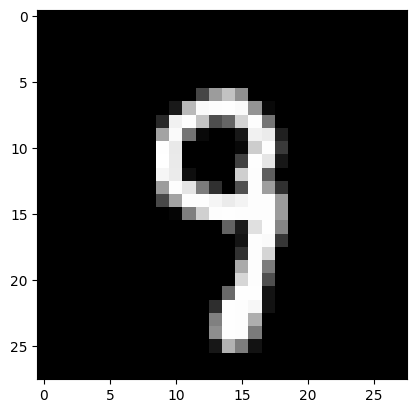

Prediction:  [0]
Label:  0


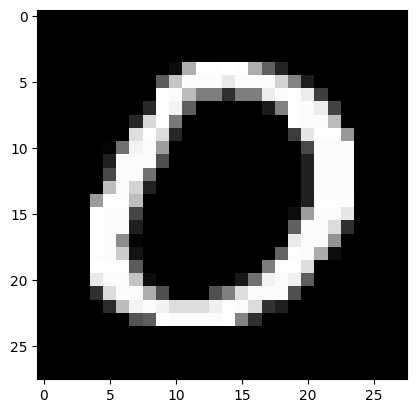

Prediction:  [5]
Label:  3


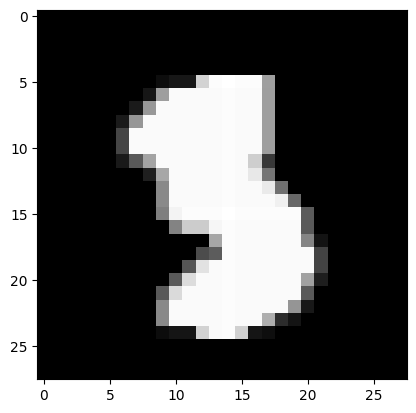

Prediction:  [2]
Label:  2


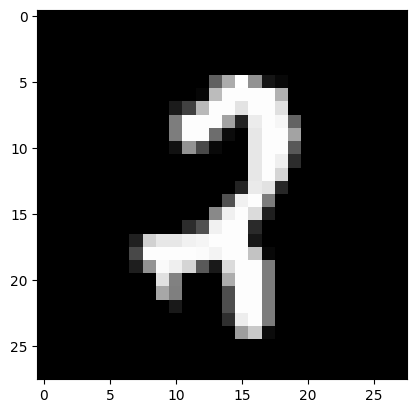

In [14]:
test_prediction(0, NN)
test_prediction(1, NN)
test_prediction(2, NN)
test_prediction(3, NN)

### Accuracy on Test set

In [15]:
dev_predictions = make_predictions(X_test, NN)
get_accuracy(dev_predictions, Y_test)

0.905